# Verifying the SpeechT5 model

I needed to do the following to be able to load the original model:

- Clone the https://github.com/microsoft/SpeechT5 repo

Install stuff:

```
pip install editdistance
pip install -U sacrebleu==1.5.1

git submodule update --init SpeechT5/fairseq
cd SpeechT5
pip install --editable fairseq/
pip install espnet
```

Put this notebook at the same level as the `SpeechT5` repo.

Hack the code:

- Copy `speecht5/tasks/speecht5.py` into `fairseq/fairseq/tasks`

- To run on CPU: In `speecht5/sequence_generator.py`, comment out where it does `.to(device="cuda")`

Additional stuff to download:

- `dict.txt` from https://drive.google.com/uc?export=download&id=19hcQ58RHZ6CssxF8Qp6yEF1NW_AXxObK

- `tokenizer` from https://drive.google.com/uc?export=download&id=1wClgQjXXoU2lmpbaEa1v2SqMbg7cAutq

- `speecht5_base_asr.pt` and `t5_transformer_lm.pt` from https://huggingface.co/ajyy/SpeechT5

You also need an input audio file, any WAV at 16 kHz will do.

In [1]:
%reload_ext autoreload
%autoreload 2

Set Python path so it can find the `speecht5` and `fairseq` modules.

In [2]:
import sys
sys.path.insert(0, "../SpeechT5/SpeechT5")
sys.path.insert(0, "../SpeechT5/SpeechT5/fairseq")

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

## Load audio and preprocess

In [4]:
input_file = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/AUDIO_DIR/dev_clean/1272/141231/1272-141231-0020.flac"

In [5]:
import soundfile as sf
wav_data, cur_sample_rate = sf.read(input_file)
wav_data.shape, cur_sample_rate

((69120,), 16000)

NOTE: The `Wav2Vec2FeatureExtractor` does not make sure the audio file is mono. If it has shape `(2, length)` or even `(1, length)` then the output from the feature extractor is incorrect!

The `do_normalize` option is False for the SpeechT5 ASR model.

In [6]:
from transformers import Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor(do_normalize=False, return_attention_mask=True)

In [7]:
inputs = feature_extractor(wav_data, sampling_rate=cur_sample_rate, padding=True, return_tensors="pt")
inputs["input_values"].shape

torch.Size([1, 69120])

In [8]:
# for testing padding mask
inputs["attention_mask"][:, 40000:] = 0

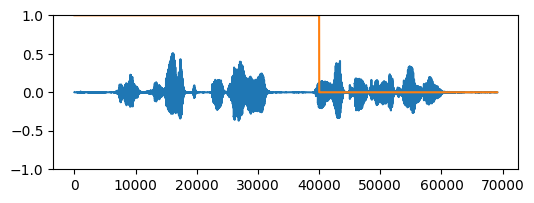

In [17]:
plt.figure(figsize=(6, 2))
plt.plot(inputs["input_values"][0])
plt.plot(inputs["attention_mask"][0])
plt.ylim(-1, 1)
plt.show()

Transform multiple inputs into a single padded batch:

In [90]:
input_file2 = "/Users/matthijs/Documents/FILES/HuggingFace/S2S/textless/AUDIO_DIR/selfdestruct.wav"
wav_data2, cur_sample_rate2 = sf.read(input_file2)
wav_data2.shape, cur_sample_rate2

((128632,), 16000)

In [91]:
inputs2 = feature_extractor([wav_data, wav_data2], sampling_rate=cur_sample_rate, padding=True, return_tensors="pt")
inputs2["input_values"].shape

torch.Size([2, 128632])

The original model used a `padding_mask` as input, where False means no padding. The `Wav2Vec2FeatureExtractor` can return an `attention_mask`, where 1 means no padding.

In [92]:
inputs2["attention_mask"]

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)

In [93]:
inputs = inputs2

## Load the Transformers model

To convert the original checkpoint weights to Transformers:

First download the checkpoint. I used `speecht5_base_asr.pt` from https://huggingface.co/ajyy/SpeechT5

Then run the following, using your own `--checkpoint_path` and `--pytorch_dump_folder_path`:

```nohighlight
cd transformers/src/transformers/models/speecht5

python convert_speecht5_original_pytorch_checkpoint_to_pytorch.py \
  --task s2t \
  --checkpoint_path /path/to/SpeechT5/speecht5_base_asr.pt 
  --pytorch_dump_folder_path /some/other/path
```

NOTE: The conversion script is currently incomplete, so it prints a warning about "Unexpected key(s) in state_dict". This is normal at this point.

In [9]:
from transformers import (
    SpeechT5Config, 
    SpeechT5CTCTokenizer,
    SpeechT5Processor,
    SpeechT5Model, 
    SpeechT5ForConditionalGeneration, 
    #SpeechT5ForCTC, 
    Wav2Vec2FeatureExtractor,
)

In [10]:
config = SpeechT5Config()
# hf_model = SpeechT5Model(config)
# hf_model = SpeechT5ForCTC(config)

In [11]:
model_checkpoint = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_asr"
# hf_model = SpeechT5Model.from_pretrained(model_checkpoint)

Note that loading should work OK for both the base class `SpeechT5Model` and `SpeechT5ForCTC`.

In [12]:
# hf_model = SpeechT5ForCTC.from_pretrained(model_checkpoint)
hf_model = SpeechT5ForConditionalGeneration.from_pretrained(model_checkpoint)

Some weights of SpeechT5ForConditionalGeneration were not initialized from the model checkpoint at /Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_asr and are newly initialized: ['lm_head.bias', 'lm_head.weight', 'speecht5.decoder.embed_tokens.weight', 'speecht5.decoder.layernorm_embedding.weight', 'speecht5.decoder.layernorm_embedding.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
hf_model.eval()

SpeechT5ForConditionalGeneration(
  (speecht5): SpeechT5Model(
    (encoder): SpeechT5Encoder(
      (speech_encoder_prenet): SpeechT5SpeechEncoderPrenet(
        (feature_encoder): SpeechT5FeatureEncoder(
          (conv_layers): ModuleList(
            (0): SpeechT5GroupNormConvLayer(
              (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
              (activation): GELUActivation()
              (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
            )
            (1): SpeechT5NoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
              (activation): GELUActivation()
            )
            (2): SpeechT5NoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
              (activation): GELUActivation()
            )
            (3): SpeechT5NoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=Fa

In [14]:
# _ = hf_model.train()
# config.mask_feature_prob = 0.9

In [15]:
# Verify the attention layer weights are correct
# for i in range(len(hf_model.speecht5.encoder.layers)):
#     print(i, "k_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.k_proj.weight == orig_model.encoder.layers[i].self_attn.k_proj.weight))
#     print(i, "k_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.k_proj.bias == orig_model.encoder.layers[i].self_attn.k_proj.bias))
#     print(i, "v_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.v_proj.weight == orig_model.encoder.layers[i].self_attn.v_proj.weight))
#     print(i, "v_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.v_proj.bias == orig_model.encoder.layers[i].self_attn.v_proj.bias))
#     print(i, "q_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.q_proj.weight == orig_model.encoder.layers[i].self_attn.q_proj.weight))
#     print(i, "q_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.q_proj.bias == orig_model.encoder.layers[i].self_attn.q_proj.bias))
#     print(i, "out_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.out_proj.weight == orig_model.encoder.layers[i].self_attn.out_proj.weight))
#     print(i, "out_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.out_proj.bias == orig_model.encoder.layers[i].self_attn.out_proj.bias))
#     print("---")

# print("pos_emb weight", torch.all(hf_model.speecht5.encoder.pos_emb.pe_k.weight == orig_model.encoder.pos_emb.pe_k.weight))

Run a single forward pass. This should run the encoder, decoder, and the relevant pre- and postnets.

In [16]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.encoder.speech_encoder_prenet(**inputs)

type(hf_outputs)

tuple

In [17]:
# Using no attention_mask
# with torch.no_grad():
#      hf_outputs = hf_model.speech_encoder_prenet(input_values=inputs["input_values"])

# type(hf_outputs)

In [18]:
# list(hf_outputs.keys())

In [19]:
# hf_outputs["extract_features"].shape

In [20]:
# hf_outputs["extract_features"]

In [21]:
# hf_outputs["hidden_states"].shape

In [22]:
# hf_outputs["hidden_states"]

In [23]:
[x.shape for x in hf_outputs if hasattr(x, "shape")]

[torch.Size([1, 215, 768]), torch.Size([1, 215, 512]), torch.Size([1, 215])]

In [24]:
hf_outputs[0]

tensor([[[ 7.4147, -3.6930, 10.6119,  ...,  1.3639,  2.2972,  0.8101],
         [ 8.1118, -4.2742, 12.2622,  ...,  0.1729,  1.6734,  0.6476],
         [-2.8165,  2.4560, -1.3008,  ...,  0.9983, -0.4333,  2.5262],
         ...,
         [ 7.7907, -6.4359,  5.6191,  ...,  0.0352,  3.1737,  0.4928],
         [-0.1691, -4.2425,  6.3816,  ..., -1.6755,  1.3843,  0.2407],
         [ 2.0105, -3.1966,  7.5800,  ..., -0.5673,  1.7153,  0.5722]]])

In [25]:
hf_encoder_input = hf_outputs[0]
hf_encoder_attention_mask = hf_outputs[2]

## Load the original model

Load the dictionary. This adds `<s>, <pad>, </s>, <unk>` tokens to the front and `<mask>` and `<ctc_blank>` to the end. **dict.txt** was [downloaded from here](https://drive.google.com/uc?export=download&id=19hcQ58RHZ6CssxF8Qp6yEF1NW_AXxObK). This is the Vocabulary link from the main SpeechT5 README.

In [28]:
from fairseq.data import Dictionary
tgt_dict = Dictionary.load("/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/DATA_ROOT/dict.txt")
tgt_dict.add_symbol("<mask>")
tgt_dict.add_symbol("<ctc_blank>")
print(f"dictionary size: " f"{len(tgt_dict):,}")

dictionary size: 81


To load the model we need the `SpeechT5Task` object but constructing it is annoying. Fortunately, `build_model` only reads two properties from the task object, so we can fake it.

In [29]:
class FakeTask:
    def __init__(self):
        self.dicts = { "text": tgt_dict }
        self.t5_task = "s2t"
        
task = FakeTask()

Load the fine-tuned ASR model.

In [30]:
import torch
from speecht5.models.speecht5 import T5TransformerModel

In [31]:
checkpoint = torch.load("../weights/SpeechT5/speecht5_base_asr.pt")

orig_model = T5TransformerModel.build_model(checkpoint["cfg"]["model"], task)

orig_model.load_state_dict(checkpoint["model"])
orig_model = orig_model.eval()

In [32]:
type(orig_model)

speecht5.models.speecht5.T5TransformerModel

In [33]:
type(orig_model.encoder)

speecht5.models.modules.encoder.TransformerEncoder

In [34]:
#list(checkpoint["model"].keys())

In [35]:
from fairseq.data import encoders
from argparse import Namespace
tokenizer = encoders.build_bpe(
    Namespace(
        bpe='sentencepiece', 
        sentencepiece_model='/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/MODEL_DIR/spm_char.model'
    )
)
type(tokenizer)

fairseq.data.encoders.sentencepiece_bpe.SentencepieceBPE

In [36]:
# orig_model.decoder.layers[0].encoder_attn

## Verify speech encoder prenet output

This first uses the `speech_encoder_prenet` to convert the raw audio data into embeddings of shape `(batch, sequence_length, 768)`. The sequence length is roughly `number of audio samples / 320`, so there is one vector every 20 ms.

In [37]:
source = inputs["input_values"]
source.shape

torch.Size([1, 69120])

In [38]:
padding_mask = torch.BoolTensor(source.shape).fill_(False)

In [39]:
padding_mask = torch.BoolTensor((1 - inputs["attention_mask"]).bool())
padding_mask

tensor([[False, False, False,  ...,  True,  True,  True]])

In [40]:
# This doesn't work on the original model
#padding_mask = None

In [41]:
encoder_input, encoder_padding_mask = orig_model.speech_encoder_prenet(
    source, padding_mask=padding_mask, mask=False
)

In [42]:
# encoder_input = orig_model.speech_encoder_prenet.feature_extractor(source)
# encoder_input.shape

In [43]:
encoder_input.shape, encoder_padding_mask.shape

(torch.Size([1, 215, 768]), torch.Size([1, 215]))

In [44]:
encoder_input

tensor([[[ 7.4147, -3.6930, 10.6119,  ...,  1.3639,  2.2972,  0.8101],
         [ 8.1118, -4.2742, 12.2622,  ...,  0.1729,  1.6734,  0.6476],
         [-2.8165,  2.4560, -1.3008,  ...,  0.9983, -0.4333,  2.5262],
         ...,
         [ 7.7907, -6.4359,  5.6191,  ...,  0.0352,  3.1737,  0.4928],
         [-0.1691, -4.2425,  6.3816,  ..., -1.6755,  1.3843,  0.2407],
         [ 2.0105, -3.1966,  7.5800,  ..., -0.5673,  1.7153,  0.5722]]])

In [45]:
#encoder_padding_mask

If the weights and model were converted correctly, this should report zero or a very small number:

In [46]:
# torch.max(torch.abs(encoder_input - hf_outputs["hidden_states"]))
torch.max(torch.abs(encoder_input - hf_outputs[0]))

tensor(1.)

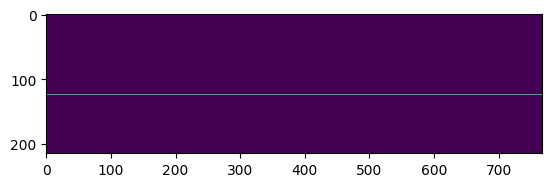

In [47]:
# plt.imshow(torch.abs(encoder_input - hf_outputs["hidden_states"]).numpy()[0] > 1e-5)
plt.imshow(torch.abs(encoder_input - hf_outputs[0]).numpy()[0] > 1e-5)

In [48]:
# torch.max(torch.abs(encoder_input - hf_outputs["extract_features"]))

In [49]:
# torch.abs(encoder_input - hf_outputs["last_hidden_state"])

## Verify Transformer encoder output

In [50]:
# Run it with the original's speech prenet input:
# with torch.no_grad():
#     encoder_output = orig_model.encoder(encoder_input, encoder_padding_mask)

In [51]:
# Run it with our input, which is slightly different (see above)
with torch.no_grad():
    encoder_output = orig_model.encoder(hf_encoder_input, ~hf_encoder_attention_mask)

In [52]:
print("encoder_out shape", encoder_output["encoder_out"][0].shape)
print("encoder_padding_mask shape", encoder_output["encoder_padding_mask"][0].shape)
print("encoder_states", encoder_output["encoder_states"])  # []
print("src_tokens", encoder_output["src_tokens"])  # []
print("decoder_input", encoder_output["decoder_input"])  # [None]
print("encoder_out_for_ctc shape", encoder_output["encoder_out_for_ctc"][0].shape)

encoder_out shape torch.Size([215, 1, 768])
encoder_padding_mask shape torch.Size([1, 215])
encoder_states []
src_tokens []
decoder_input [None]
encoder_out_for_ctc shape torch.Size([215, 1, 81])


In [53]:
encoder_output["encoder_out"][0].permute((1, 0, 2))

tensor([[[-0.3807, -0.1815, -0.5548,  ...,  0.3614, -0.8483,  0.2265],
         [-0.3834, -0.1535, -0.6543,  ...,  0.2798, -0.9170,  0.1041],
         [-0.4408, -0.1220, -0.7244,  ...,  0.2857, -0.8230, -0.0304],
         ...,
         [-0.4740, -0.2646, -0.1816,  ...,  0.2346, -0.3932,  0.2151],
         [-0.4529, -0.3011, -0.0495,  ...,  0.1883, -0.3702,  0.3084],
         [-0.4112, -0.3328, -0.2101,  ...,  0.2243, -0.3563,  0.1865]]])

In [54]:
encoder_output["encoder_out_for_ctc"][0].permute((1, 0, 2))

tensor([[[ -9.6748,  -9.7322,  -9.7790,  ...,  -9.7432,  -9.6151,  13.2914],
         [-10.0331, -10.0065, -10.1315,  ..., -10.1021, -10.0029,  13.9544],
         [-11.2495, -11.2236, -11.2750,  ..., -11.3193, -11.2077,  15.5090],
         ...,
         [-11.1690, -11.4812, -11.2688,  ..., -11.4284, -11.0229,   8.8438],
         [-10.9783, -11.2885, -11.0654,  ..., -11.2347, -10.7493,   8.8235],
         [-10.5381, -10.8706, -10.7067,  ..., -10.7471, -10.3071,   8.5327]]])

In [55]:
# Use exact same inputs as the original model:
# with torch.no_grad():
#      hf_outputs = hf_model.speecht5(
#          inputs_embeds=encoder_input,
#          attention_mask=(~encoder_padding_mask),
#      )

# type(hf_outputs)

In [63]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5(
#          inputs_embeds=hf_encoder_input,
#          attention_mask=hf_encoder_attention_mask,
         input_values=inputs.input_values,
         attention_mask=inputs.attention_mask,
     )

type(hf_outputs)

SpeechT5Model
input_values torch.Size([1, 69120])
attention_mask torch.Size([1, 69120])
decoder_input_ids None
decoder_attention_mask None
encoder_outputs None
past_key_values None


transformers.modeling_outputs.Seq2SeqModelOutput

In [64]:
hf_outputs

Seq2SeqModelOutput(last_hidden_state=None, past_key_values=None, decoder_hidden_states=None, decoder_attentions=None, cross_attentions=None, encoder_last_hidden_state=tensor([[[-0.3807, -0.1815, -0.5548,  ...,  0.3614, -0.8483,  0.2265],
         [-0.3834, -0.1535, -0.6543,  ...,  0.2798, -0.9170,  0.1041],
         [-0.4408, -0.1220, -0.7244,  ...,  0.2857, -0.8230, -0.0304],
         ...,
         [-0.4740, -0.2646, -0.1816,  ...,  0.2346, -0.3932,  0.2151],
         [-0.4529, -0.3011, -0.0495,  ...,  0.1883, -0.3702,  0.3084],
         [-0.4112, -0.3328, -0.2101,  ...,  0.2243, -0.3563,  0.1865]]]), encoder_hidden_states=None, encoder_attentions=None)

In [65]:
list(hf_outputs.keys())

['encoder_last_hidden_state']

In [66]:
hf_outputs["encoder_last_hidden_state"].shape

torch.Size([1, 215, 768])

In [67]:
hf_outputs["encoder_last_hidden_state"]

tensor([[[-0.3807, -0.1815, -0.5548,  ...,  0.3614, -0.8483,  0.2265],
         [-0.3834, -0.1535, -0.6543,  ...,  0.2798, -0.9170,  0.1041],
         [-0.4408, -0.1220, -0.7244,  ...,  0.2857, -0.8230, -0.0304],
         ...,
         [-0.4740, -0.2646, -0.1816,  ...,  0.2346, -0.3932,  0.2151],
         [-0.4529, -0.3011, -0.0495,  ...,  0.1883, -0.3702,  0.3084],
         [-0.4112, -0.3328, -0.2101,  ...,  0.2243, -0.3563,  0.1865]]])

In [68]:
torch.max(torch.abs(encoder_output["encoder_out"][0].permute((1, 0, 2)) - hf_outputs["encoder_last_hidden_state"]))

tensor(0.)

Run the full model, which also outputs the "encoder CTC":

In [54]:
# Run the full model:
with torch.no_grad():
     hf_outputs = hf_model(**inputs)

# Run without attention_mask:
# with torch.no_grad():
#     hf_outputs = hf_model(input_values=inputs["input_values"])

type(hf_outputs)

encoder_ctc torch.Size([1, 215, 81]) tensor([[[ -9.6748,  -9.7322,  -9.7790,  ...,  -9.7432,  -9.6151,  13.2914],
         [-10.0331, -10.0065, -10.1315,  ..., -10.1021, -10.0029,  13.9544],
         [-11.2495, -11.2236, -11.2750,  ..., -11.3193, -11.2077,  15.5090],
         ...,
         [-11.1690, -11.4812, -11.2688,  ..., -11.4284, -11.0229,   8.8438],
         [-10.9783, -11.2885, -11.0654,  ..., -11.2347, -10.7493,   8.8235],
         [-10.5381, -10.8706, -10.7067,  ..., -10.7471, -10.3071,   8.5327]]])


tuple

In [55]:
torch.max(torch.abs(encoder_output["encoder_out_for_ctc"][0].permute((1, 0, 2)) - hf_outputs[0]))

tensor(0.)

In [56]:
probs = torch.nn.functional.softmax(hf_outputs[0], dim=-1, dtype=torch.float32)
probs = probs.argmax(dim=-1)

In [57]:
# probs

In [58]:
# print(tgt_dict.string(probs[0]))

In [59]:
for i in range(probs.shape[0]):
    print(tokenizer.decode(tgt_dict.string(probs[i])).replace("<ctc_blank>", ""))

                jusstt   tthhrrruusstt   andd  perrrrry   ndddd


Test other methods:

In [79]:
# hf_model.prune_heads({1: [0, 2], 2: [2,3 ]})

## Verify text decoder prenet

First this calls `text_decoder_prenet`:

In [71]:
beam_size = 5
tokens = torch.tensor([2] * beam_size).reshape(beam_size, -1)
tokens.shape

torch.Size([5, 1])

In [72]:
incremental_state = {}  # no incremental state on first step

In [73]:
with torch.no_grad():
    prev_output_tokens, tgt_mask, incremental_state = orig_model.text_decoder_prenet(tokens, incremental_state)

In [74]:
prev_output_tokens.shape

torch.Size([5, 1, 768])

In [75]:
tgt_mask

In [76]:
incremental_state

{}

In [ ]:
# TODO: compare to SpeechT5 model

## Verify Transformer decoder output

In [59]:
beam_size = 5

In [60]:
prev_output_tokens = torch.rand(beam_size, 1, 768)

In [61]:
# First, reorganize the dictionary into a dictionary of lists
bsz = source.size(0)
new_order = torch.arange(bsz).view(-1, 1).repeat(1, beam_size).view(-1)
encoder_outs = orig_model.encoder.reorder_encoder_out(encoder_output, new_order)

In [62]:
new_order

tensor([0, 0, 0, 0, 0])

In [63]:
list(encoder_outs.keys())

['encoder_out',
 'encoder_padding_mask',
 'encoder_states',
 'src_tokens',
 'encoder_out_for_ctc',
 'decoder_input']

In [64]:
[(type(x), len(x)) for x in encoder_outs.values()]

[(list, 1), (list, 1), (list, 0), (list, 0), (list, 1), (list, 0)]

In [65]:
len(encoder_outs["encoder_out"])

1

In [66]:
encoder_outs["encoder_out"][0].shape, encoder_output["encoder_out"][0].shape

(torch.Size([215, 5, 768]), torch.Size([215, 1, 768]))

In [123]:
tgt_mask = None
incremental_state = {}

In [124]:
with torch.no_grad():
    decoder_output, extra = orig_model.decoder(
        prev_output_tokens,
        tgt_mask,
        encoder_out=encoder_outs,
        incremental_state=incremental_state,
    )

In [125]:
decoder_output.shape

torch.Size([5, 2, 768])

In [126]:
[x.shape for x in extra["attn"]]

[torch.Size([5, 2, 401])]

In [127]:
[x.shape for x in extra["inner_states"]]

[torch.Size([2, 5, 768]),
 torch.Size([2, 5, 768]),
 torch.Size([2, 5, 768]),
 torch.Size([2, 5, 768]),
 torch.Size([2, 5, 768]),
 torch.Size([2, 5, 768]),
 torch.Size([2, 5, 768])]

In [ ]:
# TODO verify

In [ ]:
# np.max(np.abs(extra["attn"][0].numpy() - expected))

In [ ]:
#predicted = [x.numpy() for x in extra["inner_states"]]
# for i in range(len(expected)):
#     print(np.max(np.abs(predicted[i] - expected[i])))

## Verify text decoder postnet output

In [ ]:
with torch.no_grad():
    lprobs = orig_model.text_decoder_postnet(decoder_output)

In [ ]:
lprobs.shape

In [ ]:
# TODO: verify

## Use the `transformers` generator loop:

In [65]:
# Run the full model:
with torch.no_grad():
     hf_outputs = hf_model(
         input_values=inputs.input_values,
         attention_mask=inputs.attention_mask,
         decoder_input_ids=torch.tensor([[2, 3, 4]]),
     )

type(hf_outputs)

transformers.modeling_outputs.Seq2SeqLMOutput

In [50]:
list(hf_outputs.keys())

['logits', 'past_key_values', 'encoder_last_hidden_state']

In [51]:
hf_outputs["logits"].shape

torch.Size([1, 3, 81])

In [26]:
hf_outputs = hf_model.generate(inputs.input_values, num_beams=5, max_length=3)

In [27]:
hf_outputs.shape

torch.Size([1, 3])

In [28]:
hf_outputs

tensor([[ 0, 20, 76]])

In [169]:
>>> import torch
>>> from transformers import Speech2TextProcessor, Speech2TextForConditionalGeneration
>>> from datasets import load_dataset

>>> model = Speech2TextForConditionalGeneration.from_pretrained("facebook/s2t-small-librispeech-asr")
>>> processor = Speech2TextProcessor.from_pretrained("facebook/s2t-small-librispeech-asr")

>>> ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")

>>> inputs = processor(
...     ds[0]["audio"]["array"], sampling_rate=ds[0]["audio"]["sampling_rate"], return_tensors="pt"
... )
>>> input_features = inputs.input_features

>>> generated_ids = model.generate(inputs=input_features)

>>> transcription = processor.batch_decode(generated_ids)[0]
>>> transcription
#'mister quilter is the apostle of the middle classes and we are glad to welcome his gospel'

Reusing dataset librispeech_asr_dummy (/Users/matthijs/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_dummy/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b)


'mister quilter is the apostle of the middle classes and we are glad to welcome his gospel'